# CHAPTER 09 경쟁하며 학습하는 GAN

### 9.2 GAN으로 새로운 패션 아이템 생성하기

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 장치를 사용합니다.", DEVICE)

다음 장치를 사용합니다. cuda


In [3]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [4]:
# 생성자 (Generator)
G = nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Tanh())
# 결과값은 784차원, 즉 Fashion MNIST 속의 이미지와 같은 차원의 텐서

In [5]:
# 판별자 (Discriminator)
D = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid())

In [6]:
# 모델의 가중치를 지정한 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

# 이진 크로스 엔트로피 (Binary cross entropy) 오차 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [7]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 예산
        outputs = D(images)  # real train set
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z)  # generate fake image
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake

        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차를 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [0/500], d_loss: 0.0280, g_loss: 5.0962, D(x): 1.00, D(G(z)): 0.02
Epoch [1/500], d_loss: 0.0856, g_loss: 3.6433, D(x): 0.99, D(G(z)): 0.06
Epoch [2/500], d_loss: 0.0736, g_loss: 4.9650, D(x): 0.98, D(G(z)): 0.03
Epoch [3/500], d_loss: 0.0340, g_loss: 5.8575, D(x): 0.99, D(G(z)): 0.02
Epoch [4/500], d_loss: 0.0236, g_loss: 5.7431, D(x): 0.99, D(G(z)): 0.02
Epoch [5/500], d_loss: 0.0829, g_loss: 4.8139, D(x): 0.98, D(G(z)): 0.04
Epoch [6/500], d_loss: 0.0705, g_loss: 5.8191, D(x): 0.98, D(G(z)): 0.03
Epoch [7/500], d_loss: 0.3674, g_loss: 6.6889, D(x): 0.90, D(G(z)): 0.02
Epoch [8/500], d_loss: 0.0960, g_loss: 4.7489, D(x): 0.97, D(G(z)): 0.02
Epoch [9/500], d_loss: 0.1014, g_loss: 5.1280, D(x): 0.97, D(G(z)): 0.06
Epoch [10/500], d_loss: 0.2767, g_loss: 6.2961, D(x): 0.90, D(G(z)): 0.03
Epoch [11/500], d_loss: 0.2080, g_loss: 4.4441, D(x): 0.97, D(G(z)): 0.11
Epoch [12/500], d_loss: 0.2632, g_loss: 6.7148, D(x): 0.93, D(G(z)): 0.06
Epoch [13/500], d_loss: 0.2030, g_loss: 3.6928, 

KeyboardInterrupt: ignored

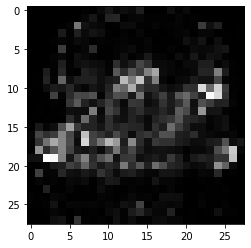

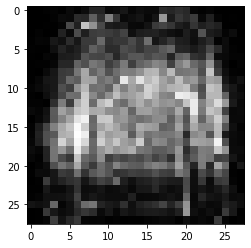

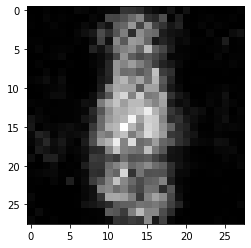

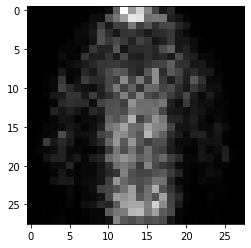

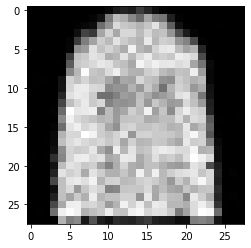

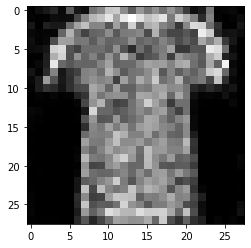

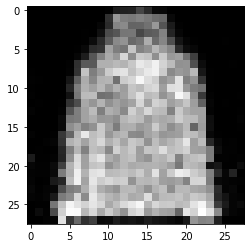

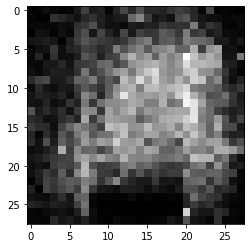

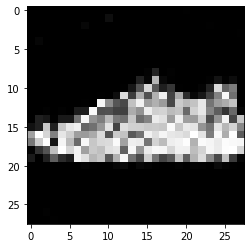

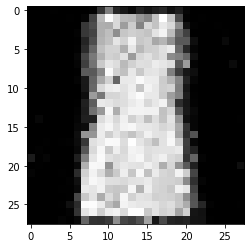

In [8]:
# 시간 문제 때문에 87/500 에폭만 돌림
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()

### 9.3 cGAN으로 생성 제어하기

In [9]:
# 하이퍼파라미터
EPOCHS = 300
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [10]:
# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),    # 110중에 10은 레이블에 관한 정보
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)

In [ ]:
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),   # 784 + 10(레이블 정보)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [ ]:
# 모델 인스턴스를 만들고 모델의 가중치를 지정한 장치로 보내기
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

# 이진 교차 엔트로피 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr =0.0002)
g_optimizer = optim.Adam(G.parameters(), lr =0.0002)

In [ ]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산 (데이터셋 레이블 입력)
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
    
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images = G(z, g_label)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산(무작위 레이블 입력)
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)

        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
          .format(epoch,
                  EPOCHS,
                  d_loss.item(),
                  g_loss.item(),
                  real_score.mean().item(),
                  fake_score.mean().item()))

In [ ]:
# 만들고 싶은 아이템 생성하고 시각화하기
item_number = 9 # 아이템 번호
z = torch.randn(1, 100).to(DEVICE) # 배치 크기 1
g_label = torch.full((1,), item_number, dtype=torch.long).to(DEVICE)
sample_images = G(z, g_label)

sample_images_img = np.reshape(sample_images.data.cpu().numpy()
                               [0],(28, 28))
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()